<a href="https://colab.research.google.com/github/MehrabiHasan/Snapchat-App/blob/master/Snapchat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Snapchat Application <h1>

This colab script is to display the concept of neural style transfer. This idea was introduced by Leon Gatsy, Alexander Ecker, and Matthias Bethge in their paper: [A Neural Algorithm for Artistic Style](http;s://arxiv.org/pdf/1508.06576.pdf?translate=1&translate=1&translate=1&translate=1)

Since this has already been talked about and has a number of great resources online, I'll instead try to provide a high level overview of how the code works.

<h3> Code Inspirations 


*   Ayush Chaurasia "Artistic Neural Style Transfer From Scratch" 
*   Rusty "rrmina" 
*   Neural Style Transfer: CodeThisCodeThat





First we'll start off by importing a our content and style photos into our code. I'll also have provide code to import your own photos into this script. However for your first run through I would suggest just going through with the example images. The content photo we're using is a photo of a great turtle and the style photo is from a painting from William Kadinsky. 

In [ ]:
### Import the Libraries
### Change this code for your own libraries
### We'll copy my github repo to get our Content and Style Images
!git clone https://github.com/MehrabiHasan/Snapchat-App.git

Cloning into 'Snapchat-App'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 61 (delta 18), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (61/61), done.


In [ ]:
#This is a manual way to import files into the script
from google.colab import files 
content_upload = files.upload()
style_upload = files.upload()

Saving attachment1590896876126.jpg to attachment1590896876126.jpg


In [ ]:
import torch 
from torchvision import transforms , models 
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# This code checks if gpu is available and can be used. 
device = ("cuda" if torch.cuda.is_available() else "cpu")

<h3>In the paper, they used a pretrained VGG19 model (Commonly used for Image Recognition). To my knowledge, you can also use other networks (VGG16, Imagenet, etc.), however in the original paper they used this network, so we'll do the same. Some notes: In the original paper, they changed all the MaxPool Layers into Average Pool to add better stability for final image quality. 




In [ ]:

model = models.vgg19(pretrained=True).features
for p in model.parameters():
    p.requires_grad = False
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
def model_activations(input,model):
    layers = {
    '0' : 'conv1_1',
    '5' : 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
    }
    features = {}
    x = input
    x = x.unsqueeze(0)
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x 
    
    return features

<h3>The next script requires us to resize both of our images and make them into tensors. Unlike the original script, we'll also normalize the tensor now, rather than in the main loop. 

In [ ]:
CONTENT_PATH = "/content/Snapchat-App/Images/Content/turtle.jpg"
STYLE_PATH = "/content/Snapchat-App/Images/Style/kadinsky.jpg"
transform = transforms.Compose([transforms.Resize(300),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


content = Image.open(CONTENT_PATH).convert("RGB")
content = transform(content).to(device)
print("COntent shape => ", content.shape)
style = Image.open(STYLE_PATH).convert("RGB")
style = transform(style).to(device)
print("Style Shape => ", style.shape)

COntent shape =>  torch.Size([3, 300, 457])
Style Shape =>  torch.Size([3, 300, 457])


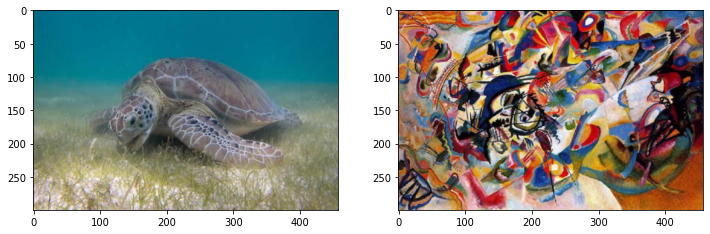

In [ ]:
def imcnvt(image):
    x = image.to("cpu").clone().detach().numpy().squeeze()
    x = x.transpose(1,2,0)
    x = x*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    return x

fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(imcnvt(content),label = "Content")
ax2.imshow(imcnvt(style),label = "Style")
plt.show()

<h3> We'll need to calculate the losses for both the content image and style image. For the style loss, we'll need to calculate the losses between individual feature maps, and to do this we'll use a gram matrix. For content loss, we'll calculate the loss by calculating the Mean Squared Error between random-noise generated image and content image. For better image quality, some researchers have found used a total-variation loss to encourage spatial smootheness. 

In [ ]:
def gram_matrix(imgfeature):
    _,d,h,w = imgfeature.size()
    imgfeature = imgfeature.view(d,h*w)
    gram_mat = torch.mm(imgfeature,imgfeature.t())
    
    return gram_mat


target = content.clone().requires_grad_(True).to(device)

#set device to cuda if available
print("device = ",device)


style_features = model_activations(style,model)
content_features = model_activations(content,model)

style_wt_meas = {"conv1_1" : 1.0, 
                 "conv2_1" : 0.8,
                 "conv3_1" : 0.4,
                 "conv4_1" : 0.2,
                 "conv5_1" : 0.1}

style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

device =  cuda


To actually form the stylized image, what we're gonna do is initalize an image of random noise. Then we're are going to apply both the style and the content features to that image and optimize after each loop. In the original paper, he used LFBG-S optimizer (which can be used), however for the purpose of this code we'll be using ADAM. 

Hyperparameter Tuning: 
Content Weight- Higher values, means the final image will appear more like the content image

Style Weight - Higher values, means the final image will appear more like the style image. 

Epochs - Training Loop 



epoch  10   tensor(2.4571e+19, device='cuda:0', grad_fn=<AddBackward0>)
epoch  20   tensor(1.4461e+19, device='cuda:0', grad_fn=<AddBackward0>)
epoch  30   tensor(8.2580e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  40   tensor(4.9453e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  50   tensor(3.1938e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  60   tensor(2.2124e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  70   tensor(1.5899e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  80   tensor(1.1833e+18, device='cuda:0', grad_fn=<AddBackward0>)
epoch  90   tensor(9.2100e+17, device='cuda:0', grad_fn=<AddBackward0>)
epoch  100   tensor(7.4682e+17, device='cuda:0', grad_fn=<AddBackward0>)
epoch  110   tensor(6.2656e+17, device='cuda:0', grad_fn=<AddBackward0>)
epoch  120   tensor(5.3936e+17, device='cuda:0', grad_fn=<AddBackward0>)
epoch  130   tensor(4.7303e+17, device='cuda:0', grad_fn=<AddBackward0>)
epoch  140   tensor(4.2074e+17, device='cuda:0', grad_fn=<Ad

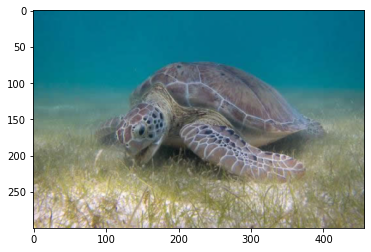

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


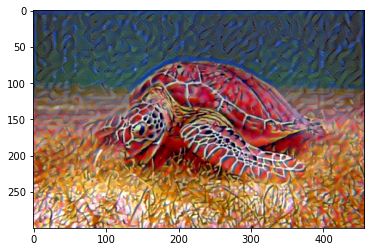

In [ ]:
content_wt = 100
style_wt = 1e8

print_after = 500
epochs = 500
optimizer = torch.optim.Adam([target],lr=0.007)

for i in range(1,epochs+1):
    target_features = model_activations(target,model)
    content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_wt_meas:
        style_gram = style_grams[layer]
        target_gram = target_features[layer]
        _,d,w,h = target_gram.shape
        target_gram = gram_matrix(target_gram)

        style_loss += (style_wt_meas[layer]*torch.mean((target_gram-style_gram)**2))/d*w*h
    
    total_loss = content_wt*content_loss + style_wt*style_loss 
    
    if i%10==0:       
        print("epoch ",i," ", total_loss)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i%print_after == 0:
        plt.imshow(imcnvt(content))
        plt.show()
        plt.imshow(imcnvt(target),label="Epoch "+str(i))
        plt.show()

Gatsy method for Neural Style Transfer allowed for any different style to be applied to the algorithm, however it's pretty slow. [Arbituary Neural Style Transfer](https://arxiv.org/abs/1703.06868) allows for the same results as Gatsy but a faster speed-up. They used added an AdaIN layer that shifts and aligns the mean and variance of the content and style features. 

We'll implement this with Tensorflow-Hub (TF-HUB). TF-HUB is a library full of great machine learning algorithms. In the previous method we showed the details in how this algorithm works, however this is more of a quick and simple way to implement 

In [ ]:
#Tensorflow Arbitrary Neural Style Transfer (Fast Method)
%matplotlib inline
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import tensorflow as tf
import numpy as np
import PIL.Image
import time
import functools

In [ ]:


def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)



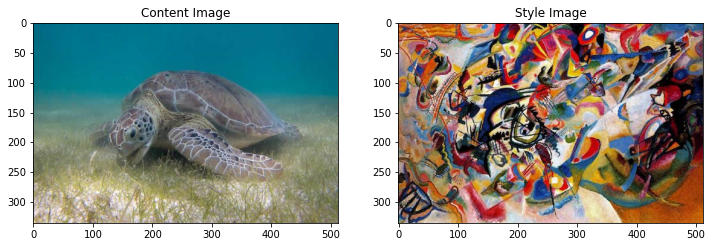

In [ ]:
content_image = load_img(CONTENT_PATH)
style_image = load_img(STYLE_PATH)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

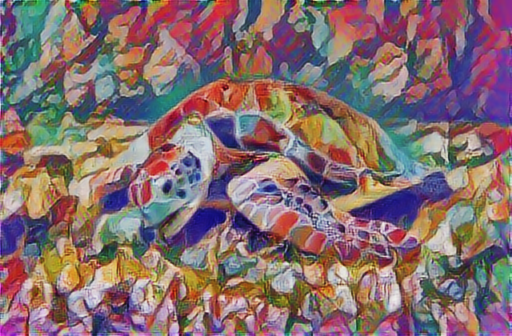

In [ ]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)